# <center>Data Mining Project 2 Spring semester 2018-2019</center>
## <center>Παναγιώτης Ευαγγελίου &emsp; 1115201500039</center>
## <center>Ευάγγελος Σπίθας &emsp;&emsp;&emsp;&ensp; 1115201500147</center>

___

## Do all the necessary imports for this notebook

In [1]:
import numpy as np
import pandas as pd
import calendar

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# clustering
from sklearn.cluster import KMeans


In [2]:
%matplotlib inline

## __Read data__

In [3]:
initialDataFrame = pd.read_csv('../data/crime.csv', engine='python')

# initialDataFrame # printToBeRemoved

## __Do some data preparation__

In [4]:
# drop the columns that we don't need
processedDataFrame = initialDataFrame.drop(['Location'], axis=1)

# replace some NaN values
processedDataFrame = processedDataFrame.fillna({'SHOOTING': "N"})

processedDataFrame['SHOOTING'].unique()  # printToBeRemoved

array(['N', 'Y'], dtype=object)

## __Data Research__

1. #### Count of crimes per year, per month, per date and per district

In [5]:
# groupBy year
# yearCountDf = processedDataFrame.groupby(['YEAR']).count() # to be removed
yearCountSeries = processedDataFrame.groupby(['YEAR'])['INCIDENT_NUMBER'].count()

# replace month numbers to month names
monthCountDf = processedDataFrame.copy()
monthCountDf['MONTH'] = monthCountDf['MONTH'].apply(lambda x: calendar.month_abbr[x])

# groupBy month
monthCountSeries = monthCountDf.groupby(['MONTH'])['INCIDENT_NUMBER'].count()
# monthCountDf = monthCountDf.groupby(['MONTH']).count() # to be removed

# groupBy day
# dayCountDf = processedDataFrame.groupby(['DAY_OF_WEEK']).count() # to be removed
dayCountSeries = processedDataFrame.groupby(['DAY_OF_WEEK'])['INCIDENT_NUMBER'].count()

# groupBy district
# districtCountDf = processedDataFrame.groupby(['DISTRICT']).count() # to be removed
districtCountSeries = processedDataFrame.groupby(['DISTRICT'])['INCIDENT_NUMBER'].count()

print("Count by year:")  # printToBeRemoved
print(yearCountSeries)  # printToBeRemoved
print("--------------")  # printToBeRemoved

print("Count by month:")  # printToBeRemoved
print(monthCountSeries)  # printToBeRemoved
print("--------------")  # printToBeRemoved

print("Count by day:")  # printToBeRemoved
print(dayCountSeries)  # printToBeRemoved
print("--------------")  # printToBeRemoved

print("Count by district:")  # printToBeRemoved
print(districtCountSeries)  # printToBeRemoved
print("--------------")  # printToBeRemoved

# for distr, count in districtCountSeries.items():
#     print("District: ", distr, " has ", count, " crimes!")

Count by year:
YEAR
2015     53392
2016     99134
2017    100938
2018     74356
Name: INCIDENT_NUMBER, dtype: int64
--------------
Count by month:
MONTH
Apr    24108
Aug    35137
Dec    23484
Feb    21661
Jan    23625
Jul    34640
Jun    30622
Mar    24156
May    26242
Nov    23685
Oct    26437
Sep    34023
Name: INCIDENT_NUMBER, dtype: int64
--------------
Count by day:
DAY_OF_WEEK
Friday       49758
Monday       46970
Saturday     45969
Sunday       41374
Thursday     47872
Tuesday      47726
Wednesday    48151
Name: INCIDENT_NUMBER, dtype: int64
--------------
Count by district:
DISTRICT
A1     36735
A15     6663
A7     13634
B2     51288
B3     36400
C11    43817
C6     24190
D14    20632
D4     43338
E13    17981
E18    17825
E5     13543
Name: INCIDENT_NUMBER, dtype: int64
--------------


2. #### Find the maximum count of shootings by year and by district

In [6]:
# replace Y -> 1, N -> 0 so as we can sum the shootings
shootingDataFrame = processedDataFrame.copy()
shootingDataFrame['SHOOTING'] = shootingDataFrame['SHOOTING'].map(dict(Y=1, N=0))

# groupBy year
yearShootings = shootingDataFrame.groupby(['YEAR'])['SHOOTING'].sum()

# groupBy district
districtShootings = shootingDataFrame.groupby(['DISTRICT'])['SHOOTING'].sum()

print("Shootings by year:")  # printToBeRemoved
print(yearShootings)  # printToBeRemoved
print("Max year is:")  # printToBeRemoved
print(yearShootings[yearShootings == yearShootings.max()])  # printToBeRemoved
print("--------------")  # printToBeRemoved
print("Shootings by district:")  # printToBeRemoved
print(districtShootings)  # printToBeRemoved
print("Max district is:")  # printToBeRemoved
print(districtShootings[districtShootings == districtShootings.max()])  # printToBeRemoved
print("--------------")  # printToBeRemoved

Shootings by year:
YEAR
2015    185
2016    279
2017    371
2018    220
Name: SHOOTING, dtype: int64
Max year is:
YEAR
2017    371
Name: SHOOTING, dtype: int64
--------------
Shootings by district:
DISTRICT
A1      12
A15      5
A7      17
B2     352
B3     227
C11    195
C6      41
D14     21
D4      59
E13     70
E18     35
E5      19
Name: SHOOTING, dtype: int64
Max district is:
DISTRICT
B2    352
Name: SHOOTING, dtype: int64
--------------


3. #### Check if crimes are more during the day than during the night

In [7]:
# make new column that represents day or night
dayNightDataFrame = processedDataFrame.copy()
dayNightDataFrame['DAY_NIGHT'] = np.where(((dayNightDataFrame['HOUR'] >= 7) & (dayNightDataFrame['HOUR'] <= 17)),
                                          'day', 'night')

dayCrimesCount = (dayNightDataFrame['DAY_NIGHT'] == 'day').sum()
nightCrimesCount = (dayNightDataFrame['DAY_NIGHT'] == 'night').sum()

print("Count of crimes during day is:")  # printToBeRemoved
print(dayCrimesCount)  # printToBeRemoved

print("Count of crimes during night is:")  # printToBeRemoved
print(nightCrimesCount)  # printToBeRemoved

# dayNightDataFrame  # printToBeRemoved

Count of crimes during day is:
184268
Count of crimes during night is:
143552


4. #### Find the most common type of crime that is committed during the day

In [8]:
# make a dataFrame that is consisted only of crimes that are committed during the day
onlyDayCrimes = dayNightDataFrame.copy()
onlyDayCrimes = onlyDayCrimes[(onlyDayCrimes['DAY_NIGHT'] == "day")]

# if we need only the name of the code then we can do the following
mostCommonOffenseCode = onlyDayCrimes['OFFENSE_CODE_GROUP'].mode()

# if we want to know the count of crimes of this type then
# groupBy by offense_code
codeCount = onlyDayCrimes.groupby(['OFFENSE_CODE_GROUP'])['INCIDENT_NUMBER'].count()

print("the most common type of crime that is committed during the day is ", mostCommonOffenseCode)
print(codeCount[codeCount == codeCount.max()])
# onlyDayCrimes  # printToBeRemoved

the most common type of crime that is committed during the day is  0    Motor Vehicle Accident Response
dtype: object
OFFENSE_CODE_GROUP
Motor Vehicle Accident Response    21852
Name: INCIDENT_NUMBER, dtype: int64


5. #### Clustering based on location

Let's try a scatter plot with seaborn first

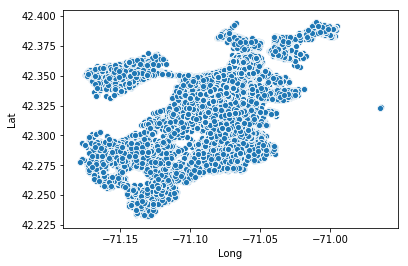

In [9]:
locationDf = processedDataFrame[['Lat', 'Long']]

# remove missing values
locationDf = locationDf.dropna()

specificLocation = locationDf.loc[(locationDf['Lat'] > 40) & (locationDf['Long'] < -60)]

ax = sns.scatterplot(x="Long", y="Lat", data=specificLocation)

Let's try matplotlib also

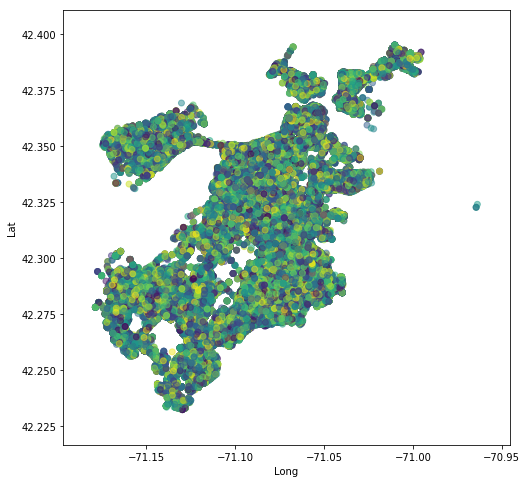

In [10]:
x = specificLocation['Long']
y = specificLocation['Lat']

colors = np.random.rand(len(specificLocation))

plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=colors, alpha=0.5)
plt.xlabel("Long")
plt.ylabel("Lat")
plt.show()

Let's do the clustering

- 2 clusters

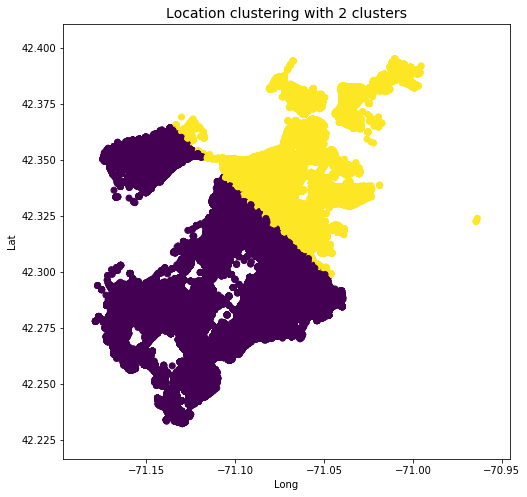

In [12]:
locationArray = specificLocation.values

# KMeans
km = KMeans(n_clusters=2)
km.fit(locationArray)
y_kmeans = km.predict(locationArray)
labels = km.labels_

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(locationArray[:,1], locationArray[:,0], c=y_kmeans)
plt.xlabel("Long")
plt.ylabel("Lat")
plt.title("Location clustering with 2 clusters", fontsize=14)
plt.show()